## Wide-narrow drops + slopes

In [10]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel
from scipy import optimize as optim

from scipy import stats

import sys
sys.path.append('Library/')

import drop_detection_tools as ddt


from tqdm import tqdm
%matplotlib inline

In [2]:
matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

<Figure size 432x288 with 0 Axes>

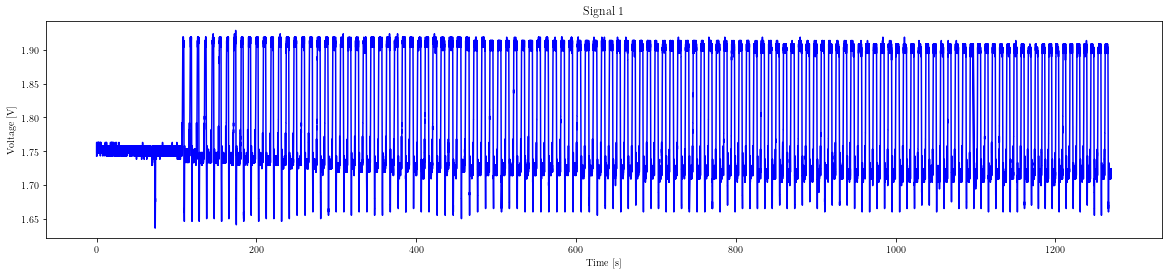

<Figure size 432x288 with 0 Axes>

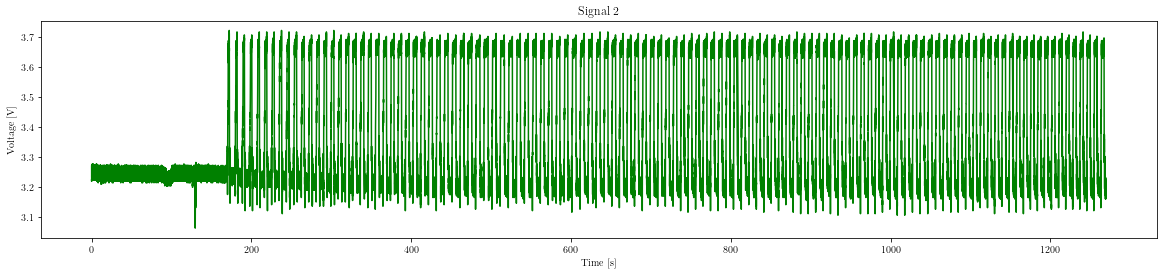

In [3]:
%matplotlib inline
#************************************
folder   = '../../T-data/2-12/'
filename = 'B-ol2-aq2-pause10.csv'
name = '2-12_B-ol2-aq2'
#************************************

raw = True


sig1, sig2, t_raw = ddt.read_LV(folder, filename)

### Resample data

Text(0.5, 1.0, 'Signal 2')

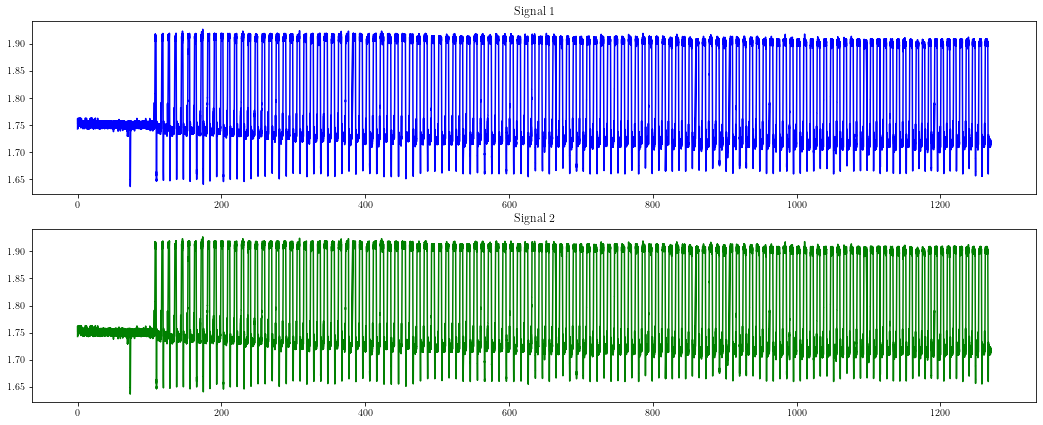

In [4]:
dt = 0.01 # sampling time

if raw:
    sig1, new_t = ddt.resample(sig1, t_raw, dt=dt)
    sig2, _ = ddt.resample(sig2, t_raw, dt=dt)
    t = new_t
    raw = False
else:
    print('data already resampled')


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,7))

axs[0].plot(t, sig1, color='blue')
axs[0].set_title('Signal 1')

axs[1].plot(t, sig1, color='green')
axs[1].set_title('Signal 2')


## Fourier transformation


In [5]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 10000   # higher cut-off frequency

### Signal 1 

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


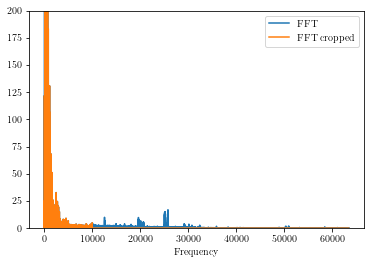

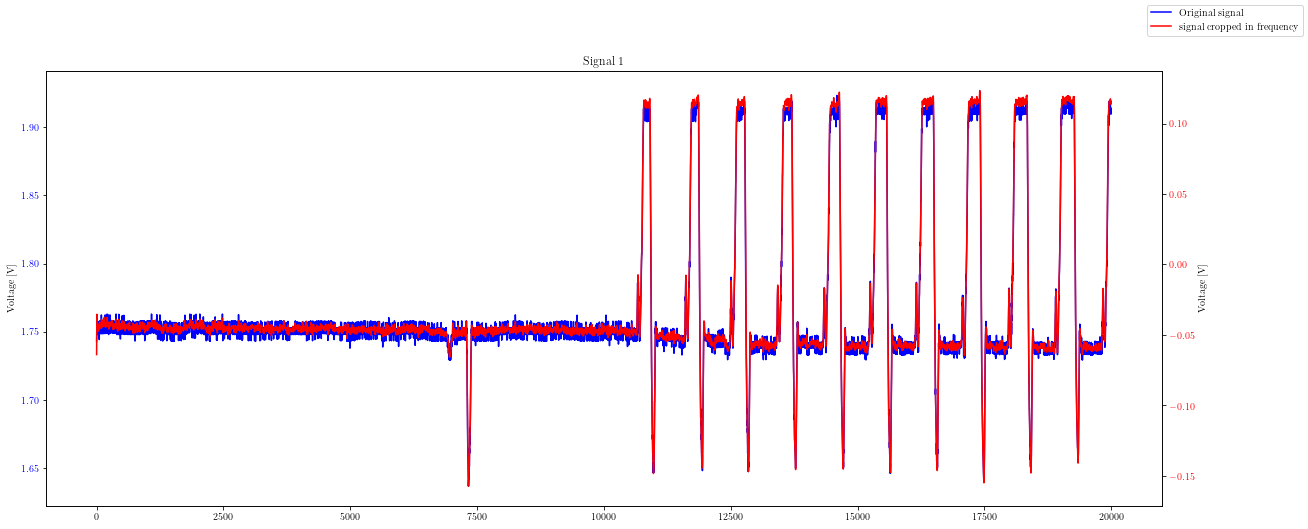

In [6]:
# FFT transform filtering
sig1_high = ddt.FFT_cropping(sig1, min_freq, max_freq)

x_min = 0       # signal plot x min.
x_max = 20000   # signal plot x max.
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'blue'
ax1.set_title('Signal 1')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig1[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor = color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()   
ax2.set_xlabel('')
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig1_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()


### Signal 2 

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


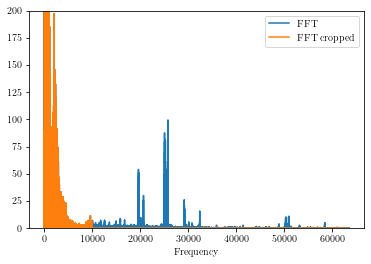

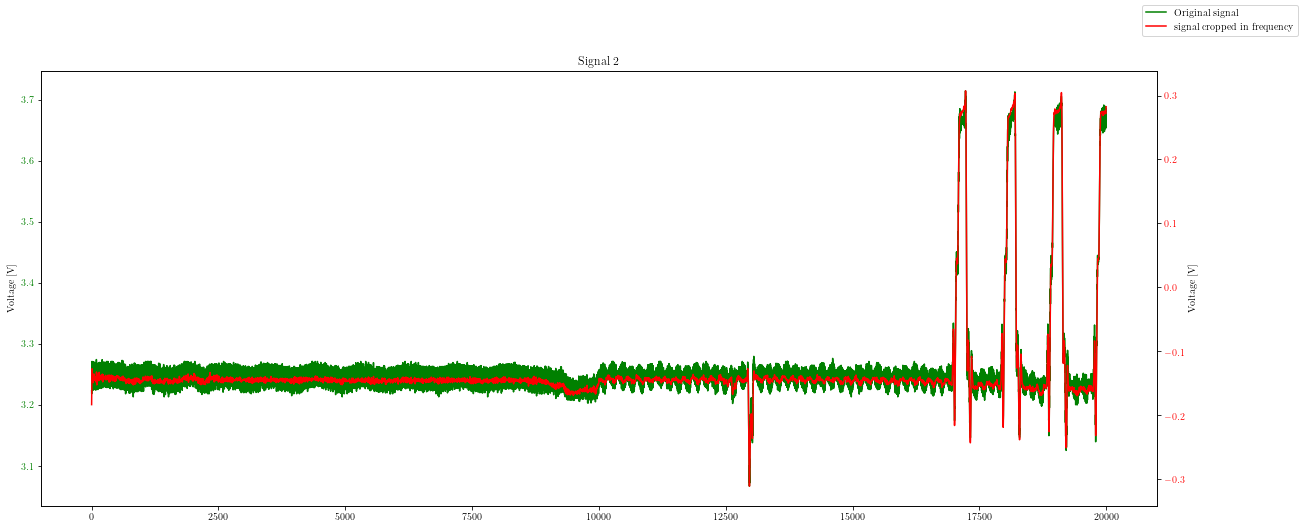

In [7]:
# FFT transform filtering
sig2_high = ddt.FFT_cropping(sig2, min_freq, max_freq)

x_min = 0    # Plot x min.
x_max = 20000  # Plot x max. 
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'green'
ax1.set_title('Signal 2')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig2[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor= color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()                                 
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig2_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()

## New rectify

In [88]:
a = np.arange(100) + 0.2

np.where((a > 20) * (a < 30))


np.concatenate([np.arange(10), np.array([])])

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [8]:
def rectify_new(signal, xrange, xdata=None, plot_switch=False, ignore_bias=-1, manual_thr=-np.inf, **kwargs):
        
    # Y-data
    signal = np.array(signal)
    
    # X-data
    if xdata is None:
        xdata = np.arange(len(signal))
    else:
        xdata = np.array(xdata)
    
    # Analysis
    main_mean  = np.mean(signal)
    lower_mean = np.mean([s for s in signal if s < main_mean])
    upper_mean = np.mean([s for s in signal if s >= main_mean])
    pivot      = 0.5*(lower_mean + upper_mean)
    
    # Fit
    def f_upper(x):
        arr = np.where((xdata < x + xrange) * (xdata > x - xrange))
        max_len = len(arr)
        arr = signal[arr]
        arr = arr[arr > pivot + ignore_bias]
        arr = np.concatenate([arr, np.array([upper_mean]*(max_len - len(arr)))])
        return np.mean(arr)

    
    def f_lower(x):
        arr = np.where((xdata < x + xrange) * (xdata > x - xrange))
        max_len = len(arr)
        arr = signal[arr]
        arr = arr[arr < pivot - ignore_bias]
        arr = arr[arr > manual_thr]
        arr = np.concatenate([arr, np.array([lower_mean]*(max_len - len(arr)))])
        return np.mean(arr)
    
    fit_curve_upper = np.array([f_upper(x) for x in xdata])
    fit_curve_lower = np.array([f_lower(x) for x in xdata])
    
    new_sig = np.copy(signal)
    for i,s in enumerate(new_sig):
        if s > pivot:
            new_sig[i] += upper_mean - fit_curve_upper[i]
        else:
            new_sig[i] += lower_mean - fit_curve_lower[i]

    
    plt.figure()
    plt.plot(xdata, signal)
    plt.plot(xdata, fit_curve_upper)
    plt.plot(xdata, fit_curve_lower)
    
    plt.figure()
    plt.plot(xdata, new_sig)
    
    return fig, new_sig

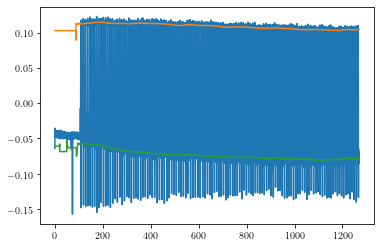

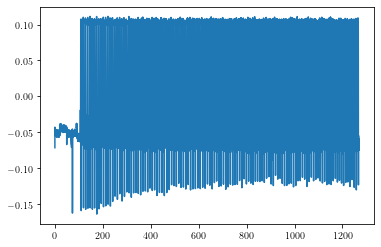

In [9]:
fig, sig1_r = rectify_new(sig1_high, xrange = 20, xdata=t, ignore_bias=0.07, manual_thr=-0.1)

<IPython.core.display.Javascript object>


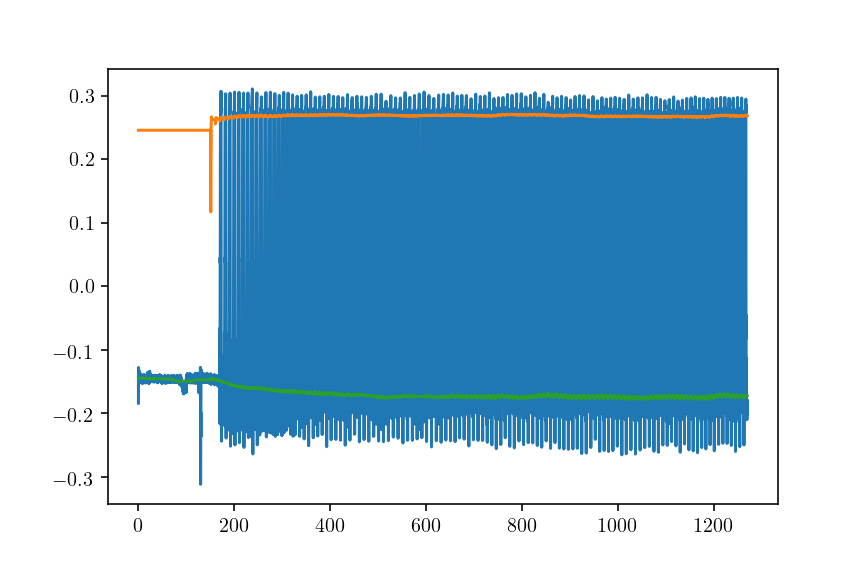

<IPython.core.display.Javascript object>


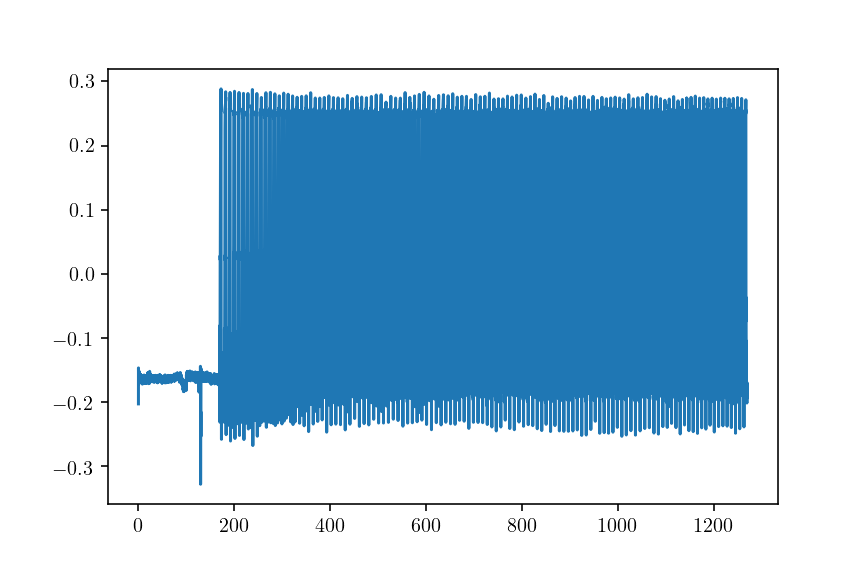

In [67]:
fig, sig2_r = rectify_new(sig2_high, xrange = 20, xdata=t, ignore_bias=0.07, manual_thr=-0.3)

## Thresholds computing

modified the output of the function, to get also sigma_high and sigma_low

In [11]:
def thr_searcher(Ydata, nbins=20, low_sigmas=3, high_sigmas=5, plot_switch=True,
                 Xdata=None, ymin=None, ymax=None, c01=None, c02=None, **kwargs):
    
    '''
    Description:
        Oscillating data finds the two threshold to identify peaks (droplets)
    
    Params:
        - Ydata:       array with oscillating data
        - nbins:       number of bins for the histogram to find the two thresholds
        - low_sigmas:  number of sigmas above the low mean where to put the lower thr
        - high_sigmas: number of sigmas below the high mean where to put the higher thr
        - plot_switch: if True shows plots
        - Xdata:       array with the matching time (or space) to the data
        - ymin, ymax:  ylims for the plot
        
    Returns:
        thr_low, thr_high
    '''
    
    xlabel = kwargs.pop('xlabel',None)
    ylabel = kwargs.pop('ylabel',None)
    
    if xlabel is None:
        xlabel = 'position [mm]'
    if ylabel is None:
        ylabel = 'luminosity'
    
    if plot_switch:
        #plt.clf() # Clear figure
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        freq,bins,p = axes[0].hist(Ydata, nbins, **kwargs)
    
    # Histogram definition
    else:
        freq,bins,p = plt.hist(Ydata, nbins, color='green')
    x = 0.5 *(bins[:-1] + bins[1:])
    max_freq = np.max(freq)                                     
        
    # Gaussian 1
    gauss1 = GaussianModel(prefix='g1_')
    pars   = gauss1.make_params(center=x[0]+(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max(freq))

    # Gaussian 2
    gauss2 = GaussianModel(prefix='g2_')
    pars.update(gauss2.make_params())
    
    if c01 is None:
        # Gaussian 1 parameters
        pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
        #pars['g1_sigma'].set(max=(x[-1]-x[0])/10, min=(x[-1]-x[0])/30)
        #pars['g1_amplitude'].set(value=max(freq)/20,min=10)
    else:
        pars['g1_center'].set(value = c01)

    # Gaussian 2 parameters
    if c02 is None:
        c02 = x[-1]-(x[-1]-x[0])/10
        
    pars['g2_center'].set(value=c02)
    pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
    pars['g2_amplitude'].set(value=max(freq))

    mod  = gauss1 + gauss2
    init = mod.eval(pars, x=x)
    out  = mod.fit(freq, pars, x=x)

    
    if plot_switch:
        # Plot histo
        axes[0].plot(x, out.init_fit, 'k--', label='initial fit')
        axes[0].plot(x, out.best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')
        axes[0].set_title("Signal histogram")
        axes[0].set_xlabel(ylabel)
        axes[0].set_ylabel("Number of events")
        
        if axes[0].get_ylim()[1] > 1.5*max_freq:
            axes[0].set_ylim(0,1.5*max_freq)

    center2 = out.best_values.get('g2_center')
    sigma2  = out.best_values.get('g2_sigma')
    center1 = out.best_values.get('g1_center')
    sigma1  = out.best_values.get('g1_sigma')

    
    max_freq1 = max(freq[x<center1+sigma1])
    x_max1    = x[np.argmax(freq[x<center1+2*sigma1])]
    max_freq2 = max(freq[x>center2-sigma2])
    a         = x > center2-sigma2
    freq2     = np.zeros(len(freq))
    for i in range(len(a)): 
        if a[i]==True: freq2[i]=freq[i]
    x_max2 = x[np.argmax(freq2)]
       
    # Thresholds computing
    thr_low  = x_max1 + low_sigmas *sigma1
    thr_high = x_max2 - high_sigmas*sigma2
    
    # Signal plot
    if plot_switch:
        axes[0].vlines([thr_low], *axes[0].get_ylim(), color='cyan')
        axes[0].vlines([thr_high], *axes[0].get_ylim(), color='yellow')
        
        if Xdata is None:
            Xdata = np.arange(len(Ydata))
        
        axes[1].plot(Xdata, Ydata, **kwargs)
        axes[1].plot(thr_high*np.ones(len(Xdata)), color='yellow', label='thr high')
        axes[1].plot(thr_low *np.ones(len(Xdata)), color='cyan', label='thr low')
        plt.legend()
        plt.xlim((0, Xdata[len(Xdata)-1]))
        if not (ymin is None or ymax is None):
            axes[1].set_ylim(ymin, ymax)
        axes[1].set_title("Signal with thresholds")
        axes[1].set_xlabel(xlabel)
        axes[1].set_ylabel(ylabel)
        
    if thr_low > thr_high:
        print('WARNING: thr_low > thr_high')
    
    return thr_low, thr_high, sigma1, sigma2

### Signal 1

<IPython.core.display.Javascript object>


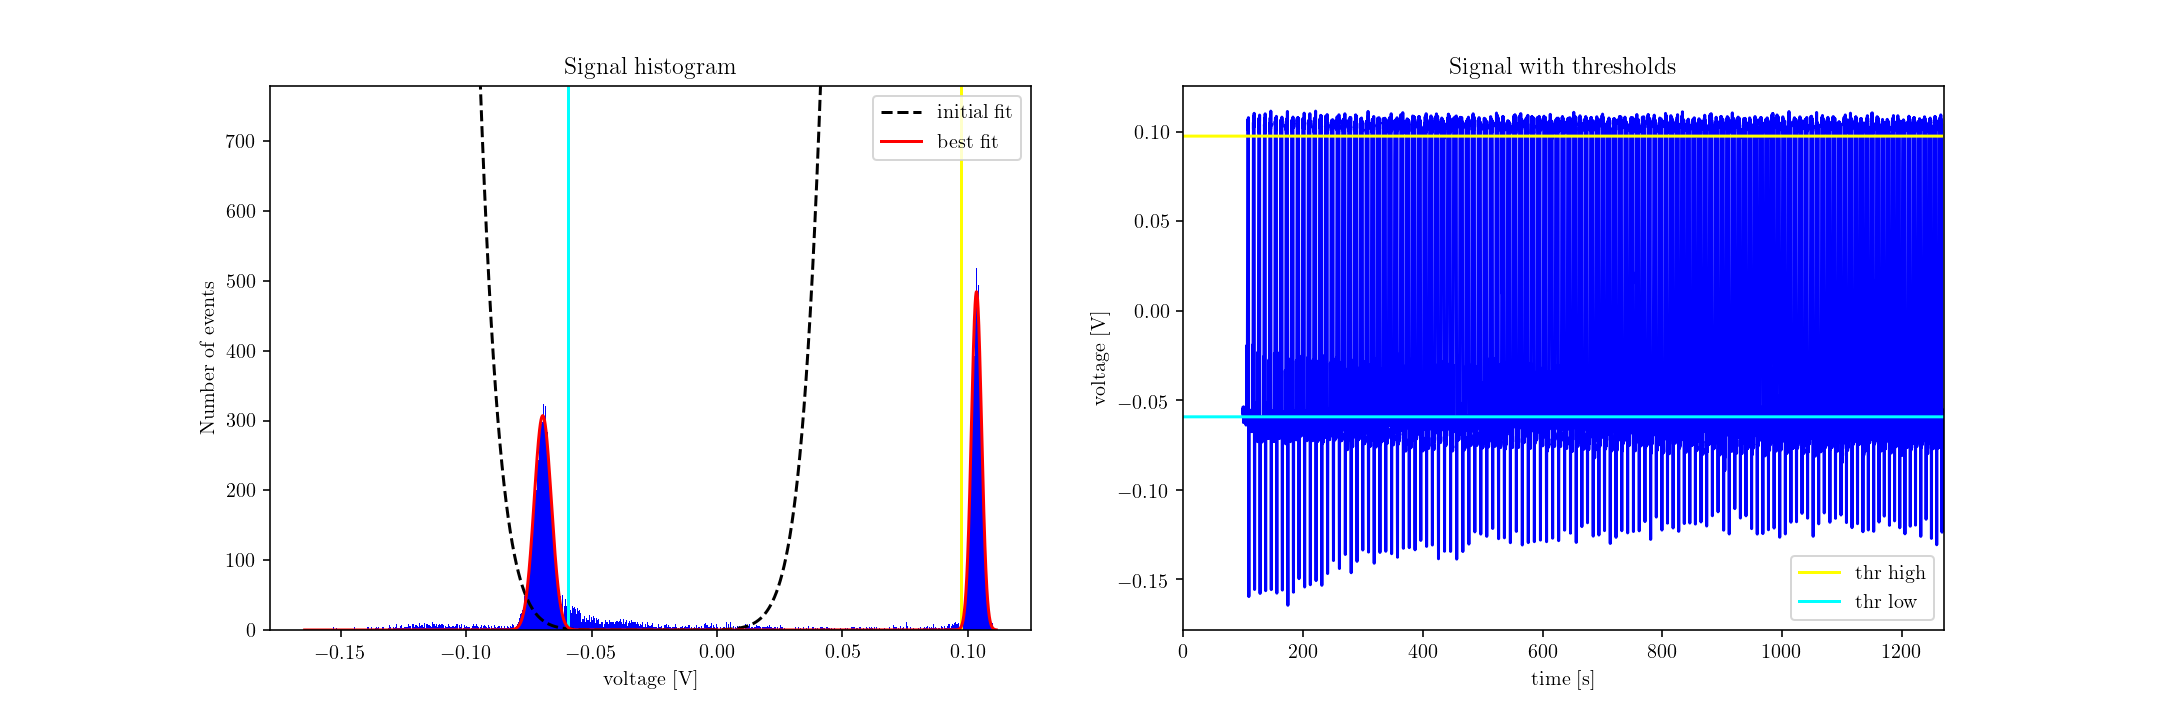

0.0034106862167269103 0.0020142507806508725


In [28]:
# %matplotlib notebook
%matplotlib notebook

start_idx_1 = 10000

returns = thr_searcher(sig1_r[start_idx_1:], 5000, high_sigmas=3, low_sigmas=3, Xdata=t[start_idx_1:],
                       color='blue', xlabel='time [s]', ylabel='voltage [V]')

thr_low_1, thr_high_1, sigma_low_1, sigma_high_1 = returns

print(sigma_low_1, sigma_high_1)

<IPython.core.display.Javascript object>


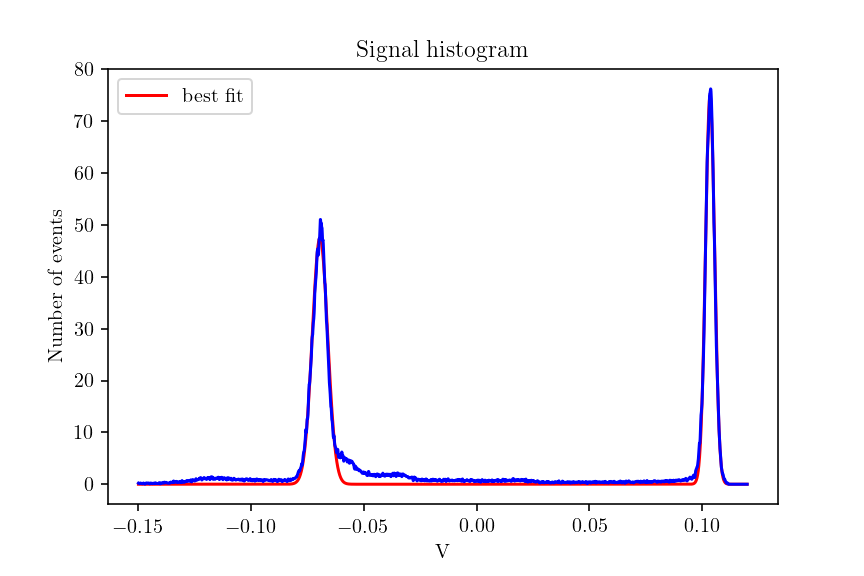

0.003413722323741375 0.002018474265641057


In [32]:
kde = stats.gaussian_kde(sig1_r[start_idx_1:],bw_method=1.42e-3)

x = np.linspace(-0.15, 0.12, 5000)
freq = kde(x)

max_freq = np.max(freq)

c01 = -0.07
c02 = 0.105


# Gaussian 1
gauss1 = GaussianModel(prefix='g1_')
pars   = gauss1.make_params(center=x[0]+(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max_freq)

# Gaussian 2
gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

if c01 is None:
    # Gaussian 1 parameters
    pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
    #pars['g1_sigma'].set(max=(x[-1]-x[0])/10, min=(x[-1]-x[0])/30)
    #pars['g1_amplitude'].set(value=max(freq)/20,min=10)
else:
    pars['g1_center'].set(value = c01)

# Gaussian 2 parameters
if c02 is None:
    c02 = x[-1]-(x[-1]-x[0])/10

pars['g2_center'].set(value=c02)
pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
pars['g2_amplitude'].set(value=max(freq))

mod  = gauss1 + gauss2
init = mod.eval(pars, x=x)
out  = mod.fit(freq, pars, x=x)

center2 = out.best_values.get('g2_center')
sigma2  = out.best_values.get('g2_sigma')
center1 = out.best_values.get('g1_center')
sigma1  = out.best_values.get('g1_sigma')

fig, ax = plt.subplots()

# ax.plot(x, out.init_fit, 'k--', label='initial fit')
ax.plot(x, out.best_fit, 'r-', label='best fit')
ax.legend(loc='best')
ax.set_title("Signal histogram")
ax.set_xlabel('V')
ax.set_ylabel("Number of events")

if ax.get_ylim()[1] > 1.5*max_freq:
    ax.set_ylim(0,1.5*max_freq)



ax.plot(x, freq, color='blue')


print(sigma1, sigma2)

### Signal 2

<IPython.core.display.Javascript object>


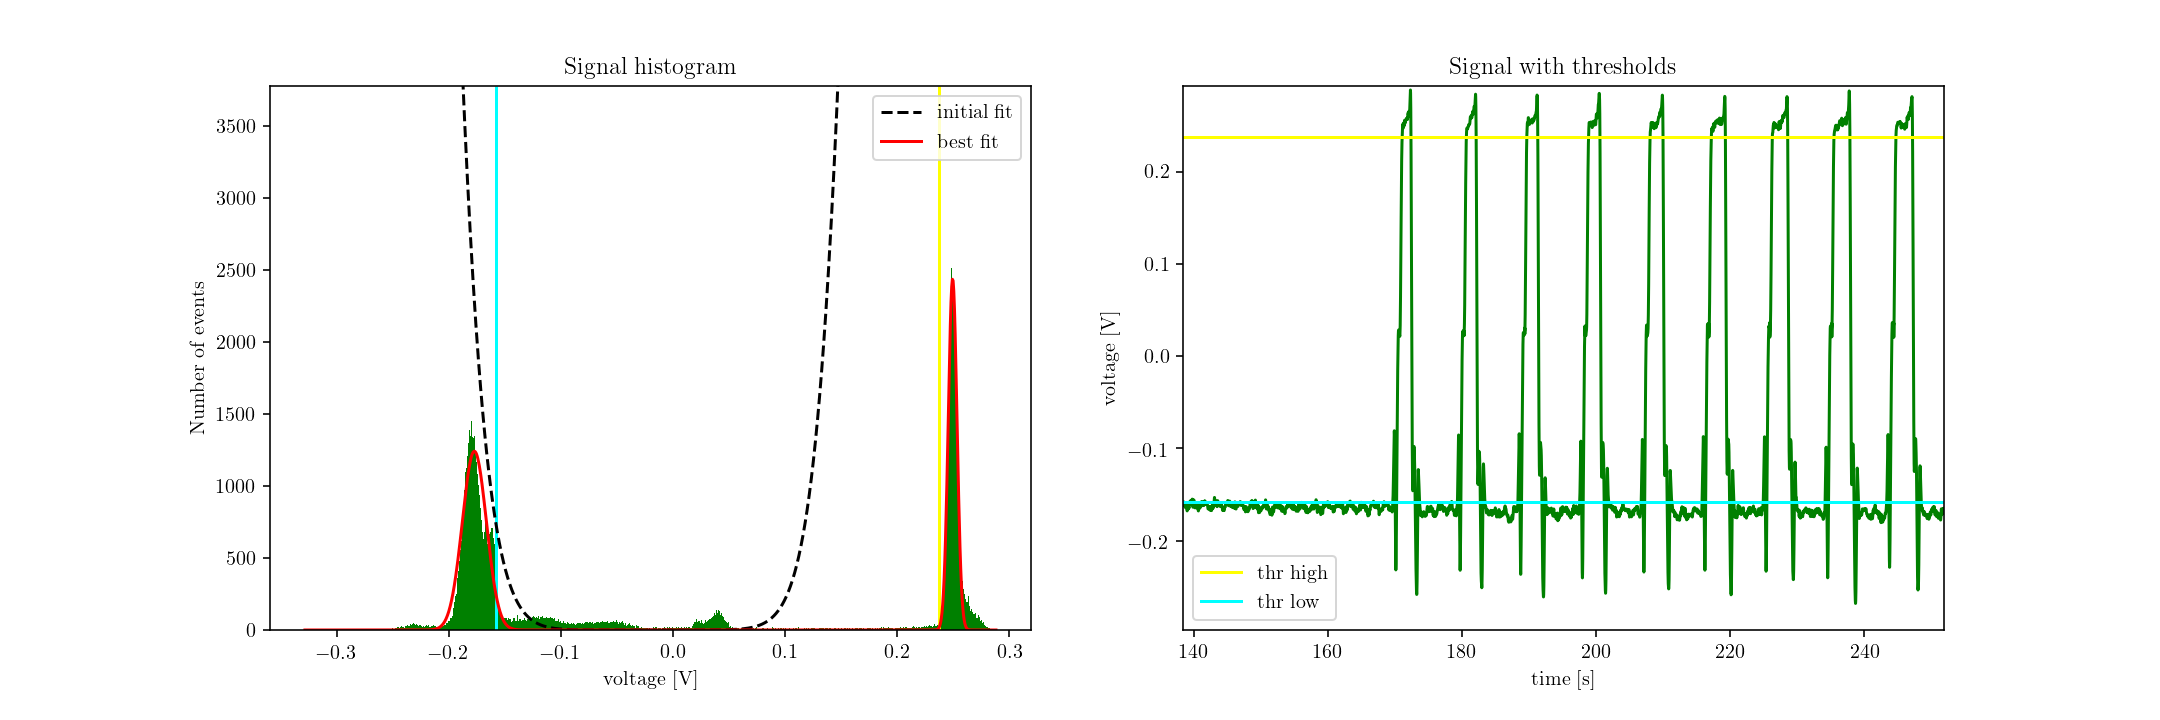

In [73]:
start_idx_2 = 8000

returns = thr_searcher(sig2_r[start_idx_2:], 1000, high_sigmas=3, low_sigmas=2, Xdata=t[start_idx_2:],
                       color='green', xlabel='time [s]', ylabel='voltage [V]')

thr_low_2, thr_high_2, sigma_low_2, sigma_high_2 = returns

In [40]:
# thr_low_2, thr_high_2 = ddt.thr_searcher(sig2_high[8000:], 1000, high_sigmas=4, low_sigmas=8, Xdata=t[8000:],
#                                          color='blue', xlabel='time [s]', ylabel='voltage [V]')

## Drops detection

In [15]:
# print(bounds) #new drop detection: narrow_start, narrow_end, wide_start, wide end

def drop_det_new(Xdata, Ydata, thr_low, thr_high, backward_skip = 1, forward_skip = 1, return_indexes=True,
                 plot_switch=True, ymin=None, ymax=None, xrange=None, **kwargs):
    
    '''
    Description:
        Identifies the start and end position of the droplets in the narrow and wide range
    
    Params:
        - Xdata:             array with time (space)
        - Ydata:             array with the voltage/luminosity values
        - thr_low, thr_high: threshold computed with 'thr_seracher'
        - plot_switch:       if True shows plots
        - ymin, ymax:        ylims for the plot
        - xrange:            width of the window to be shown (expressed in time/space units)
        
    Returns:
        narrow_start, narrow_end, wide_start, wide_end : arrays with starts and ends of the droplets
                                                         They have always the same lenght and *_start[0] < *_end[0],
                                                         i.e. no spurious detections
    '''
    xlabel = kwargs.pop('xlabel', None)
    ylabel = kwargs.pop('ylabel', None)
    
    
    # Masks
    bool_high  = Ydata > thr_high
    bool_low   = Ydata < thr_low
    
    #first cycle finds narrow_start. 
    #drop_ends are detected when drop goes below thr_low.
    #we don't need them, but they are necessary to the correct narrow_start detection
    #narrow_start is what we previously called drop_start, drop_end is the old drop_end
    narrow_start = [0]
    drop_end   = [1]
   
    for i in range(len(Ydata)-1):
        
        if bool_high[i]==False and bool_low[i+1]==False and bool_high[i+1]==True:
            if narrow_start[-1] < drop_end[-1] and i > drop_end[-1]:
                narrow_start.append(i)
                
        elif bool_low[i]==False and bool_low[i+1]==True and bool_high[i+1]==False:
            if narrow_start[-1] > drop_end[-1] and i > narrow_start[-1]:
                drop_end.append(i)
                
    #second cycle finds narrow_end. Now we call ascent_start the point where the drop goes beyond thr_low.
    ascent_start=[0]
    narrow_end=[1]
    
    for i in range(len(Ydata)-1):
        
        if bool_low[i]==True and bool_high[i]==False and bool_low[i+1]==False:
            if ascent_start[-1] < narrow_end[-1] and i > narrow_end[-1]:
                ascent_start.append(i)
                
        elif bool_low[i]==False and bool_high[i]==True and bool_high[i+1]==False  :
            if i > ascent_start[-1]:
                if ascent_start[-1] > narrow_end[-1]:
                    narrow_end.append(i)
                else: 
                    narrow_end[-1]=i      #make sure to take the real narrow_end, not just a fluctuation in the middle of the drop
                
                
    # Selection
    narrow_start = narrow_start[1:]
    narrow_end   = narrow_end[1:]
    ascent_start = ascent_start[1:]
    drop_end     = drop_end[1:] 
    # Cropping
    if len(narrow_start) > len(narrow_end):
        narrow_start = narrow_start[:-1] 
    print(len(narrow_start), len(narrow_end))
                
    #find wide_start and wide_end. Only need low thr:
    #check whenever signal simply overcomes low threshold and stores those indices
    # wide start: last spike that goes beyond low threshold before ascent_start
    # wide_end: first spike to go below low threshold after drop_end
    
    spike_start=[]
    spike_end=[]
    wide_start=[]
    wide_end=[]
    
    for i in range(len(Ydata)-1):
        if bool_low[i]==True and bool_low[i+1]==False:
            spike_start.append(i)
        elif bool_low[i]==False and bool_low[i+1]==True:
            spike_end.append(i)
            
    spike_start = np.array(spike_start)
    spike_end = np.array(spike_end)
    
    b=0
    a=0
    for start,end in list(zip(narrow_start,narrow_end)):
        #print(start,end)
        if len(spike_start[spike_start<start])>1:
            a = spike_start[spike_start<start][-(1 + backward_skip)]
            wide_start.append(a)
        if b>a: print(t[start],'s: WRONG WIDE DROP DETECTION')
        if len(spike_end[spike_end>end])>1:
            b = spike_end[spike_end>end][forward_skip]
            wide_end.append(b)
        
    #cropping
    if len(wide_start) > len(wide_end):
        wide_start = wide_start[:-1] 
    if len(narrow_start)>len(wide_start):
        narrow_start = narrow_start[:-1] 
        narrow_end = narrow_end[:-1] 
        
    print(len(narrow_start), len(narrow_end))
    
    # Plotting 
    if plot_switch:
        if xrange is None:
            xrange = Xdata[-1]
        for j in range(int (Xdata[-1]/xrange)):
            fig, ax = plt.subplots(figsize=(20,4))
            plt.plot(Xdata, Ydata, **kwargs)
            
            if ymin is None or ymax is None:
                ymin, ymax = ax.get_ylim()
            else:
                plt.ylim(ymin, ymax)
            
            for i in range(len(narrow_end)-1):

                plt.vlines(Xdata[narrow_start[i]], ymin, ymax, color='green')
                plt.vlines(Xdata[narrow_end[i]],   ymin, ymax, color='red')
                plt.vlines(Xdata[wide_start[i]],ymin, ymax, color='lime')
                plt.vlines(Xdata[wide_end[i]],ymin, ymax, color='orange')

            plt.ylabel(xlabel)
            plt.xlabel(ylabel)
            plt.xlim(j*xrange,(j+1)*xrange)
            plt.plot(thr_high*np.ones(len(Xdata)), color='yellow')
            plt.plot(thr_low *np.ones(len(Xdata)), color='cyan')
            plt.show()
         
    if not return_indexes: #         Number acquisition -> time [s] conversion
        narrow_start = Xdata[narrow_start]
        narrow_end   = Xdata[narrow_end]
        wide_start   = Xdata[wide_start]
        wide_end     = Xdata[wide_end]
    
        
    return np.array(narrow_start), np.array(narrow_end), np.array(wide_start), np.array(wide_end)

In [33]:
## new version
# print(bounds) #new drop detection: narrow_start, narrow_end, wide_start, wide end

def drop_det_new(Xdata, Ydata, thr_low, thr_high, backward_skip = 1, forward_skip = 1, return_indexes=True,
                 plot_switch=True, ymin=None, ymax=None, xrange=None, **kwargs):
    
    '''
    Description:
        Identifies the start and end position of the droplets in the narrow and wide range
    
    Params:
        - Xdata:             array with time (space)
        - Ydata:             array with the voltage/luminosity values
        - thr_low, thr_high: threshold computed with 'thr_seracher'
        - plot_switch:       if True shows plots
        - ymin, ymax:        ylims for the plot
        - xrange:            width of the window to be shown (expressed in time/space units)
        
    Returns:
        narrow_start, narrow_end, wide_start, wide_end : arrays with starts and ends of the droplets
                                                         They have always the same lenght and *_start[0] < *_end[0],
                                                         i.e. no spurious detections
    '''
    xlabel = kwargs.pop('xlabel', None)
    ylabel = kwargs.pop('ylabel', None)
    
    
    # Masks
    bool_high  = Ydata > thr_high
    bool_low   = Ydata < thr_low
    
    #first cycle finds narrow_start. 
    #drop_ends are detected when drop goes below thr_low.
    #we don't need them, but they are necessary to the correct narrow_start detection
    #narrow_start is what we previously called drop_start, drop_end is the old drop_end
    narrow_start = [0]
    drop_end   = [1]
   
    for i in range(len(Ydata)-1):
        
        if bool_high[i]==False and bool_low[i+1]==False and bool_high[i+1]==True:
            if narrow_start[-1] < drop_end[-1] and i > drop_end[-1]:
                narrow_start.append(i)
                
        elif bool_low[i]==False and bool_low[i+1]==True and bool_high[i+1]==False:
            if narrow_start[-1] > drop_end[-1] and i > narrow_start[-1]:
                drop_end.append(i)
                
    #second cycle finds narrow_end. Now we call ascent_start the point where the drop goes beyond thr_low.
    ascent_start=[0]
    narrow_end=[1]
    
    for i in range(len(Ydata)-1):
        
        if bool_low[i]==True and bool_high[i]==False and bool_low[i+1]==False:
            if ascent_start[-1] < narrow_end[-1] and i > narrow_end[-1]:
                ascent_start.append(i)
                
        elif bool_low[i]==False and bool_high[i]==True and bool_high[i+1]==False  :
            if i > ascent_start[-1]:
                if ascent_start[-1] > narrow_end[-1]:
                    narrow_end.append(i)
                else: 
                    narrow_end[-1]=i      #make sure to take the real narrow_end, not just a fluctuation in the middle of the drop
                
                
    # Selection
    narrow_start = narrow_start[1:]
    narrow_end   = narrow_end[1:]
    ascent_start = ascent_start[1:]
    drop_end     = drop_end[1:] 
    # Cropping
    if len(narrow_start) > len(narrow_end):
        narrow_start = narrow_start[:-1] 
    print(len(narrow_start), len(narrow_end))
                
    #find wide_start and wide_end. Only need low thr:
    #check whenever signal simply overcomes low threshold and stores those indices
    # wide start: last spike that goes beyond low threshold before ascent_start
    # wide_end: first spike to go below low threshold after drop_end
    
    spike_start=[]
    spike_end=[]
    wide_start=[]
    wide_end=[]
    
    for i in range(len(Ydata)-1):
        if bool_low[i]==True and bool_low[i+1]==False:
            spike_start.append(i)
        elif bool_low[i]==False and bool_low[i+1]==True:
            spike_end.append(i)
            
    spike_start = np.array(spike_start)
    spike_end = np.array(spike_end)
    
    b=0
    a=0
    for start,end in list(zip(narrow_start,narrow_end)):
        #print(start,end)
        if len(spike_start[spike_start<start])>1:
            if backward_skip > 0:
                a_start = spike_start[spike_start<start][-(1 + backward_skip)]
                a_end = spike_start[spike_start<start][-(backward_skip)] - 1
                peak_idx = np.argmax(Ydata[a_start:a_end])
                a = a_start + peak_idx
            else:
                a = spike_start[spike_start<start][-(1 + backward_skip)]
            wide_start.append(a)
        if b>a: print(t[start],'s: WRONG WIDE DROP DETECTION')
        if len(spike_end[spike_end>end])>1:
            if forward_skip > 0:
                b_start = spike_end[spike_end>end][forward_skip - 1] + 1
                b_end = spike_end[spike_end>end][forward_skip]
                peak_idx = np.argmax(Ydata[b_start:b_end])
                b = b_start + peak_idx
            else:
                b = spike_end[spike_end>end][forward_skip]
            wide_end.append(b)
        
    #cropping
    if len(wide_start) > len(wide_end):
        wide_start = wide_start[:-1] 
    if len(narrow_start)>len(wide_start):
        narrow_start = narrow_start[:-1] 
        narrow_end = narrow_end[:-1] 
        
    print(len(narrow_start), len(narrow_end))
    
    # Plotting 
    if plot_switch:
        if xrange is None:
            xrange = Xdata[-1]
        for j in range(int (Xdata[-1]/xrange)):
            fig, ax = plt.subplots(figsize=(20,4))
            plt.plot(Xdata, Ydata, **kwargs)
            
            if ymin is None or ymax is None:
                ymin, ymax = ax.get_ylim()
            else:
                plt.ylim(ymin, ymax)
            
            for i in range(len(narrow_end)-1):

                plt.vlines(Xdata[narrow_start[i]], ymin, ymax, color='green')
                plt.vlines(Xdata[narrow_end[i]],   ymin, ymax, color='red')
                plt.vlines(Xdata[wide_start[i]],ymin, ymax, color='lime')
                plt.vlines(Xdata[wide_end[i]],ymin, ymax, color='orange')

            plt.ylabel(xlabel)
            plt.xlabel(ylabel)
            plt.xlim(j*xrange,(j+1)*xrange)
            plt.plot(thr_high*np.ones(len(Xdata)), color='yellow')
            plt.plot(thr_low *np.ones(len(Xdata)), color='cyan')
            plt.show()
         
    if not return_indexes: #         Number acquisition -> time [s] conversion
        narrow_start = Xdata[narrow_start]
        narrow_end   = Xdata[narrow_end]
        wide_start   = Xdata[wide_start]
        wide_end     = Xdata[wide_end]
    
        
    return np.array(narrow_start), np.array(narrow_end), np.array(wide_start), np.array(wide_end)

### Signal 1

123 123
123 123


<IPython.core.display.Javascript object>


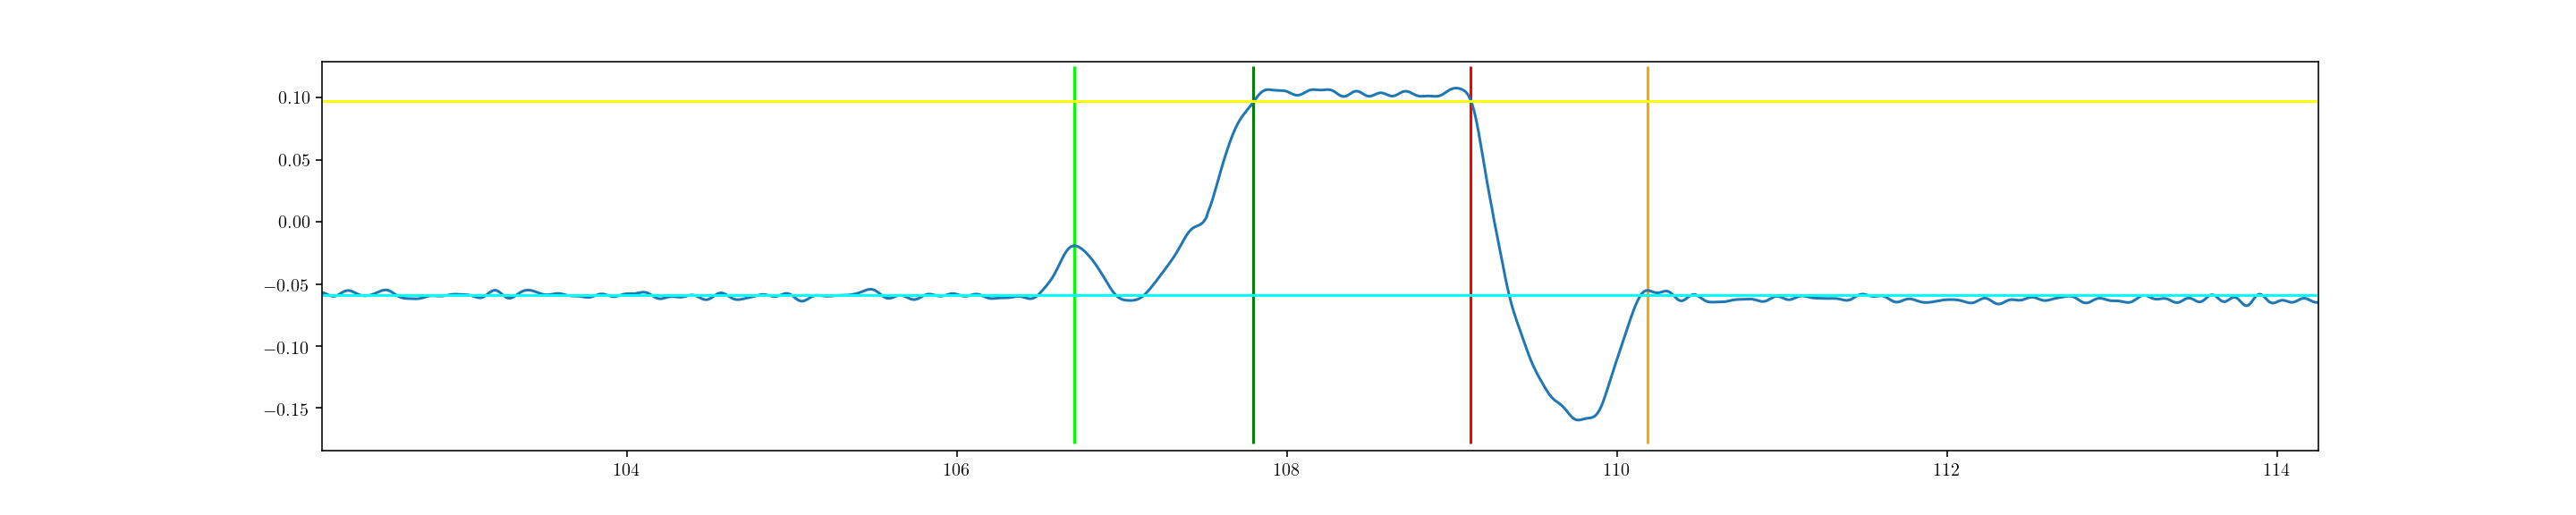

<IPython.core.display.Javascript object>


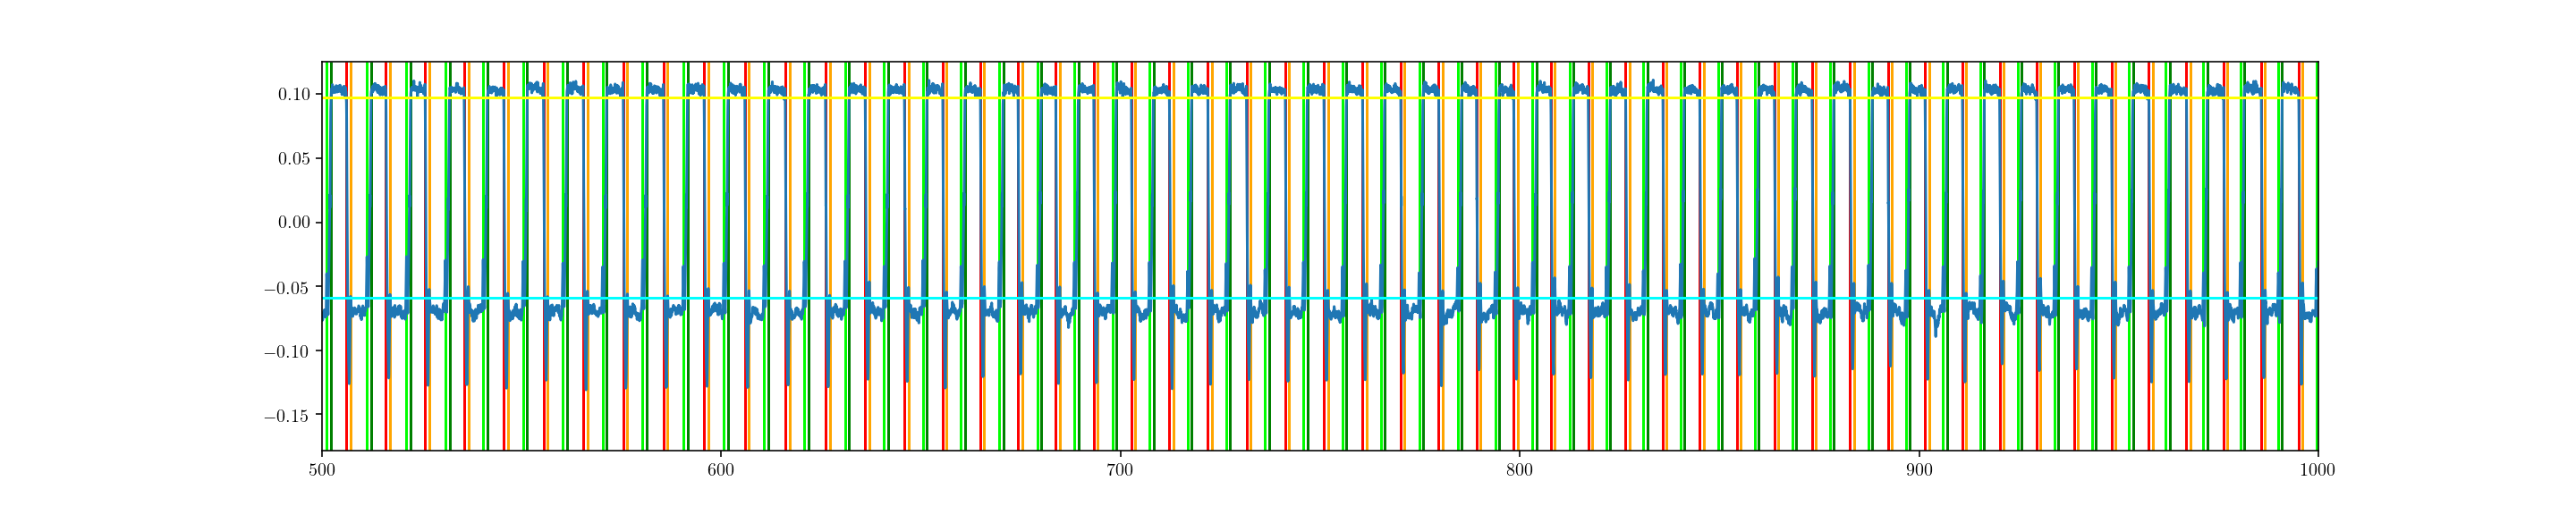

In [34]:
%matplotlib notebook
xrange       =    500    # single plot x range [s]
returns = drop_det_new(t, sig1_r, thr_low_1, thr_high_1, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True)

narrow_start_1, narrow_end_1, wide_start_1, wide_end_1 = returns
#function modified to give output arrays in index form, not in seconds.

### Signal 2

117 117
117 117


<IPython.core.display.Javascript object>


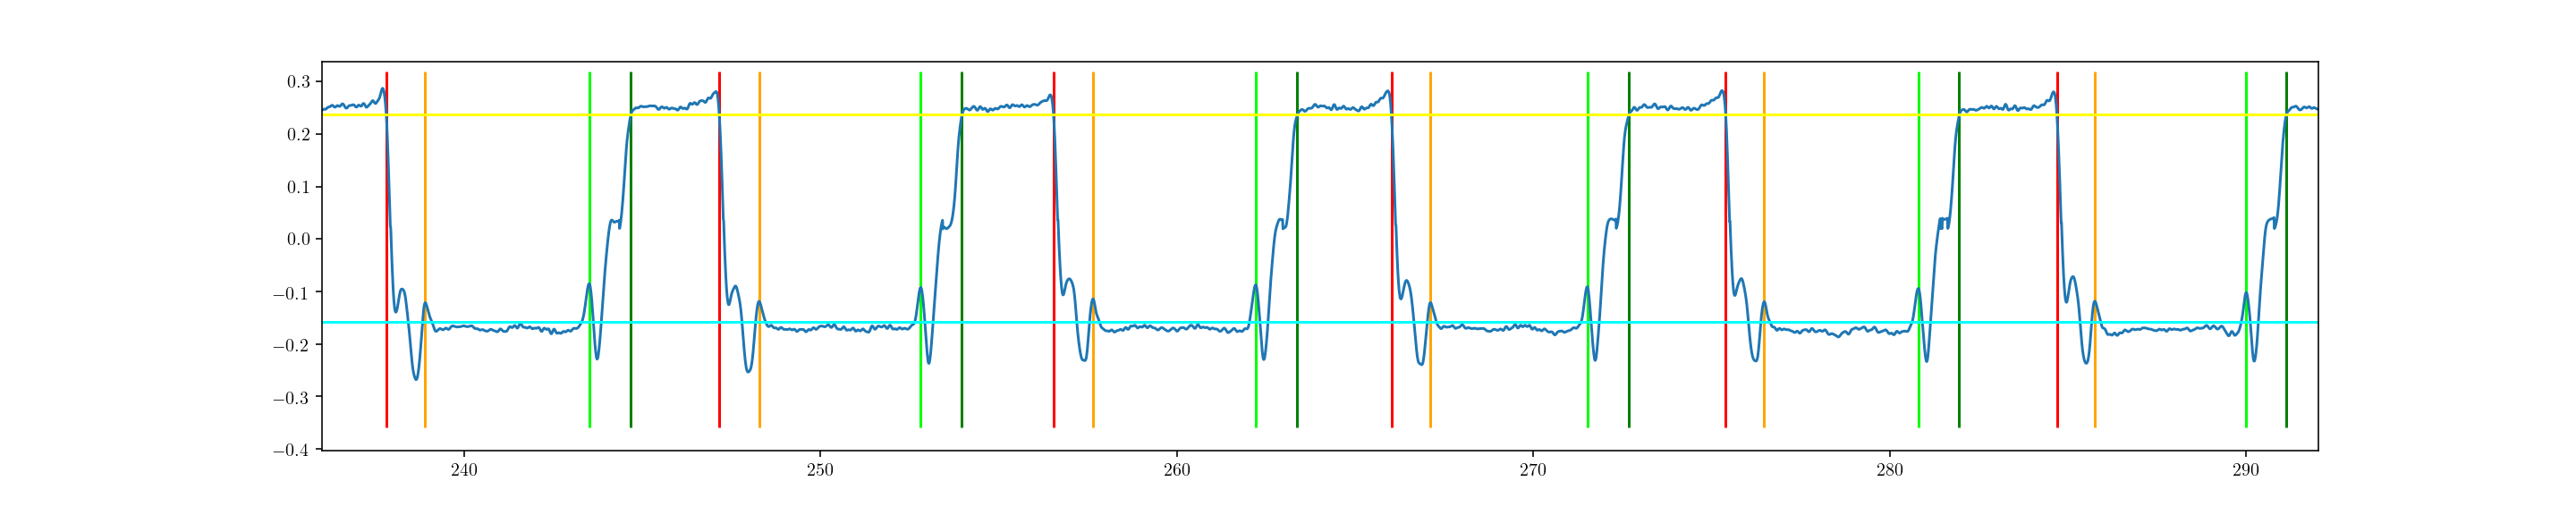

<IPython.core.display.Javascript object>


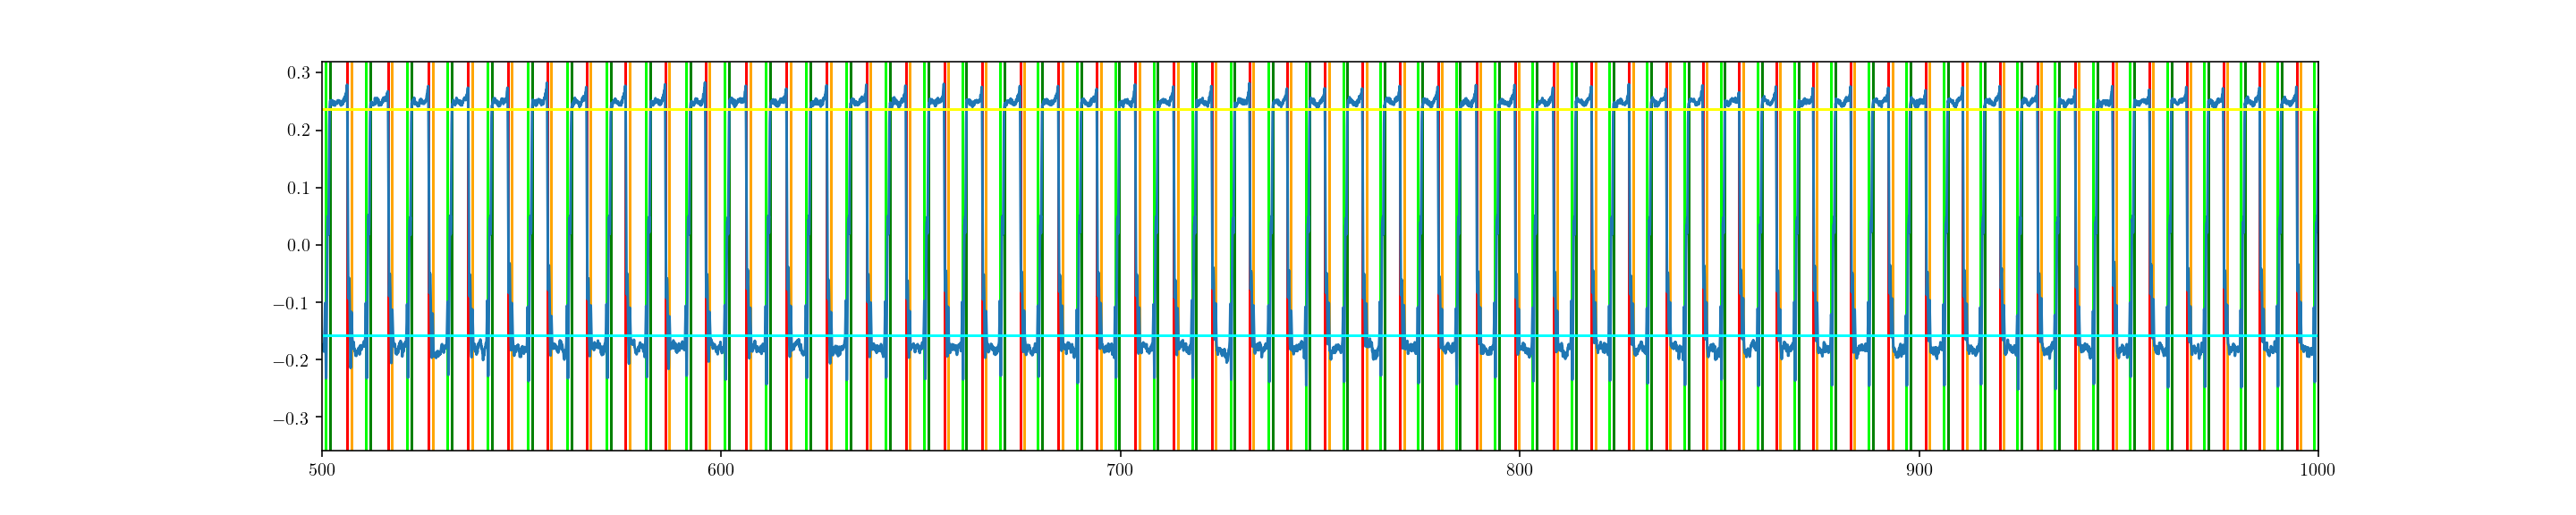

In [74]:
xrange       = 500           # single plot x range [s]

returns = drop_det_new(t, sig2_r, thr_low_2, thr_high_2, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True)

narrow_start_2, narrow_end_2, wide_start_2, wide_end_2 = returns
#function modified to give output arrays in index form, not in seconds.

## Slope function

In [37]:
# calculate slope around narrow_start and narrow_end
def slopes(Xdata, Ydata, narrow_start, narrow_end, start_range, end_range):

    def lin_func(x,a,b):
        return a*x + b
    
    slope_start = []
    slope_end   = []
    
    fig, ax = plt.subplots(figsize=(13,6))
    ax.plot(Xdata,Ydata, color='blue', alpha = 0.5)
    
    for n_start, n_end in list(zip(narrow_start,narrow_end)):
        x = Xdata[n_start-start_range:n_start+start_range]
        y = Ydata[n_start-start_range:n_start+start_range]
        popt, pcov = optim.curve_fit(lin_func, x, y)
        slope_start.append(popt[0])
        #example plot

        fit_curve = lin_func(x,*popt)
        ax.plot(x, fit_curve, color='green')

        x = Xdata[n_end-end_range:n_end+end_range]
        y = Ydata[n_end-end_range:n_end+end_range]
        popt, pcov = optim.curve_fit(lin_func, x, y)
        slope_end.append(popt[0])
        
        fit_curve = lin_func(x,*popt)
        ax.plot(x, fit_curve, color='red')

            
    return np.array(slope_start), np.array(slope_end)


<IPython.core.display.Javascript object>


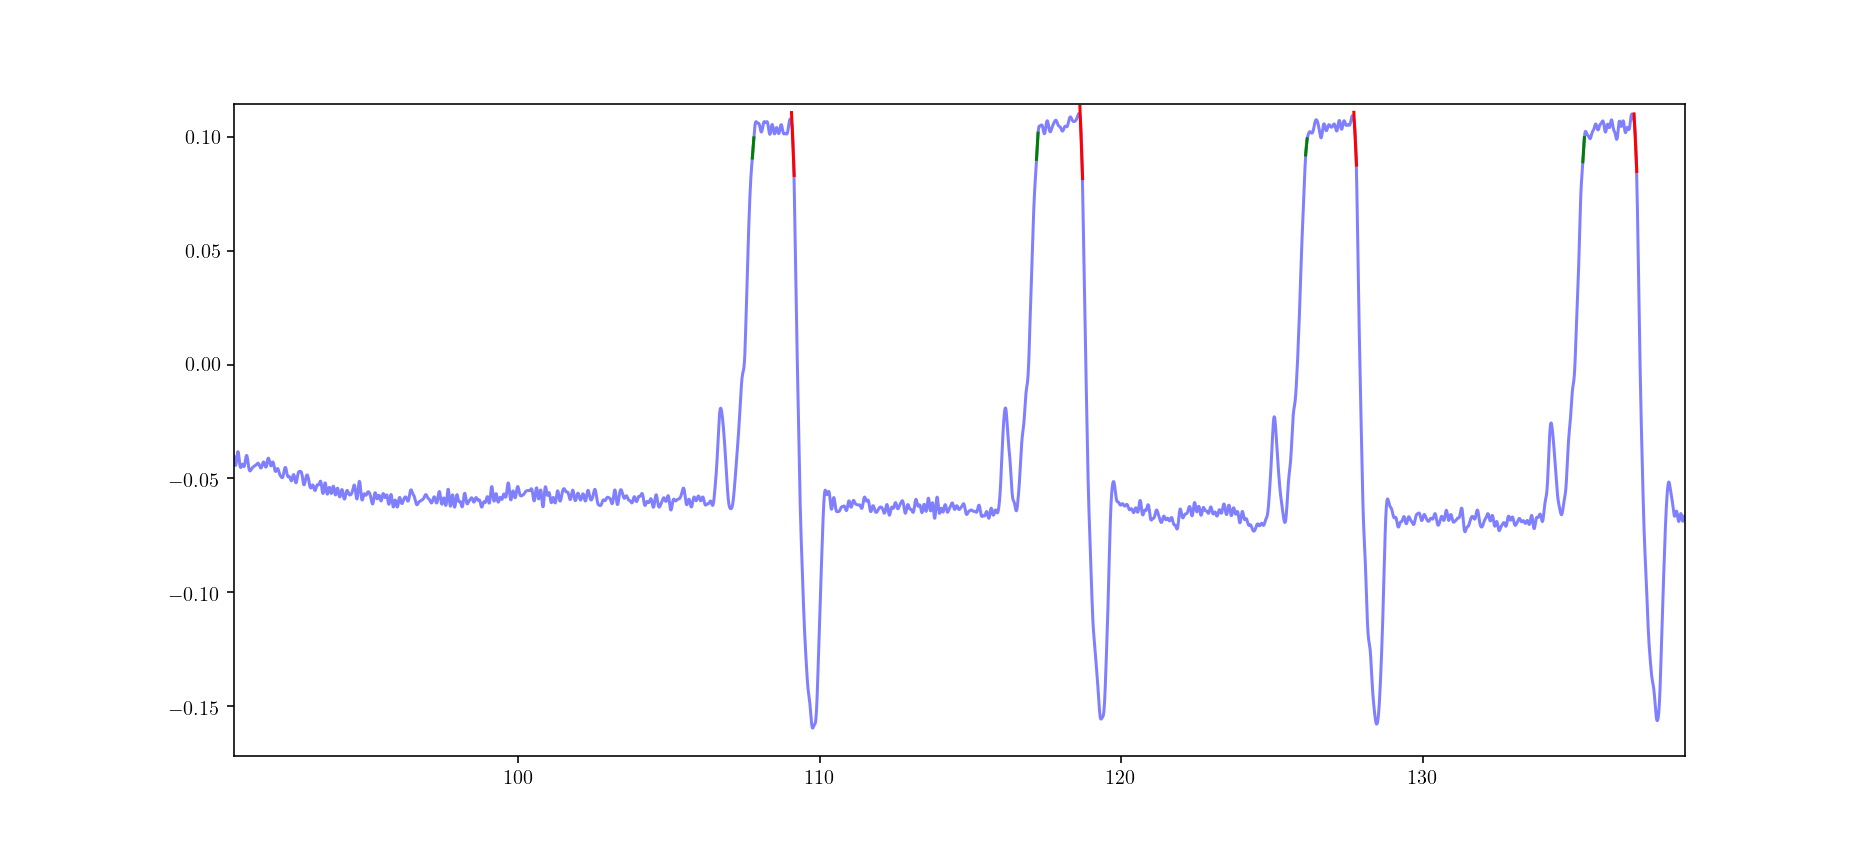

In [38]:
slope_start_1, slope_end_1=slopes(t,sig1_r, narrow_start_1, narrow_end_1, start_range=3, end_range = 5)


<ipython-input-47-fdd29d2b269b>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(13,6))


<IPython.core.display.Javascript object>


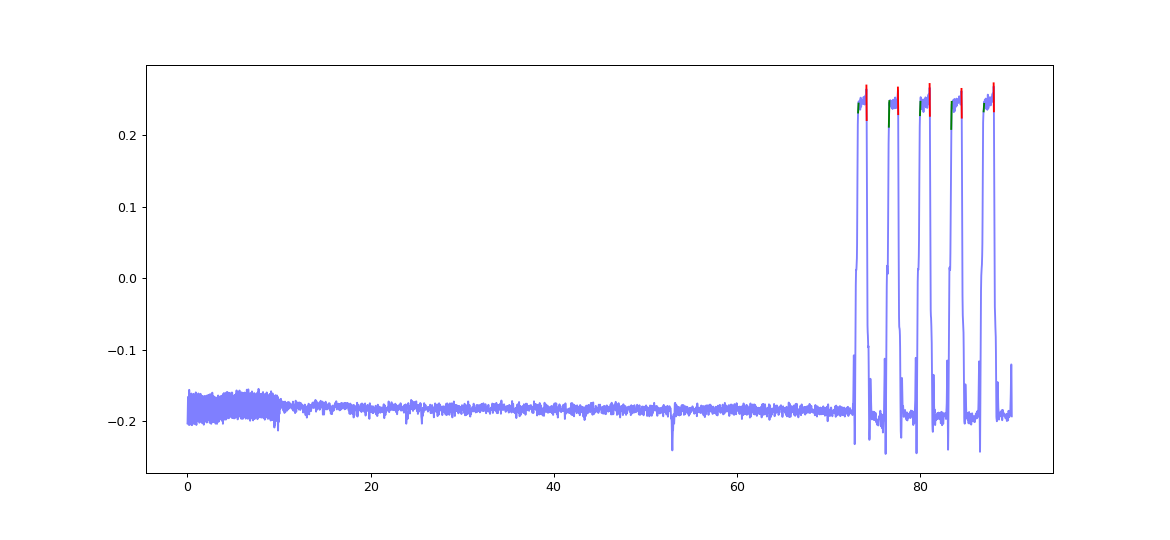

In [49]:
slope_start_2, slope_end_2=slopes(t,sig2_high, narrow_start_2, narrow_end_2, start_range=3, end_range = 2)

In [39]:
list(zip(slope_start_1, slope_end_1))

[(0.17695088117231395, -0.3069706523423628),
 (0.23035464902914127, -0.3522677404958432),
 (0.14279343062980768, -0.2577712584344417),
 (0.21206248787075802, -0.28038462390039937),
 (0.07909595524116778, -0.36850045259402536),
 (0.21571229770934902, -0.3698473286035125),
 (0.17941943540505403, -0.29818744517723594),
 (0.10982180156184981, -0.3055906527102257),
 (0.22650519542676578, -0.2843831317849627),
 (0.10609347098792639, -0.3146356148101584),
 (0.04469910634101216, -0.28203620874061247),
 (0.10601487593301208, -0.2923311971322375),
 (0.22215352751767273, -0.3691633625602636),
 (0.16224803511490532, -0.2567231784241286),
 (0.04094158271262633, -0.2951915829009342),
 (0.13308399668818457, -0.25223861098094497),
 (0.16697551446848605, -0.30033089194916657),
 (0.240454946068346, -0.32151115091777094),
 (0.16334878828962118, -0.24527613488299382),
 (0.11320894534700918, -0.23522807005375976),
 (0.018789508048213267, -0.23080252997252187),
 (0.11712276997758621, -0.2847568928045965),
 

### First error calculation

In [47]:
v_err_1 = sigma_high_1
t_err_start_1 = v_err_1/slope_start_1
t_err_end_1 = -v_err_1/slope_end_1

# v_err_2 = sigma_high_2
# t_err_2 = v_err_2/slope_start_2

<IPython.core.display.Javascript object>


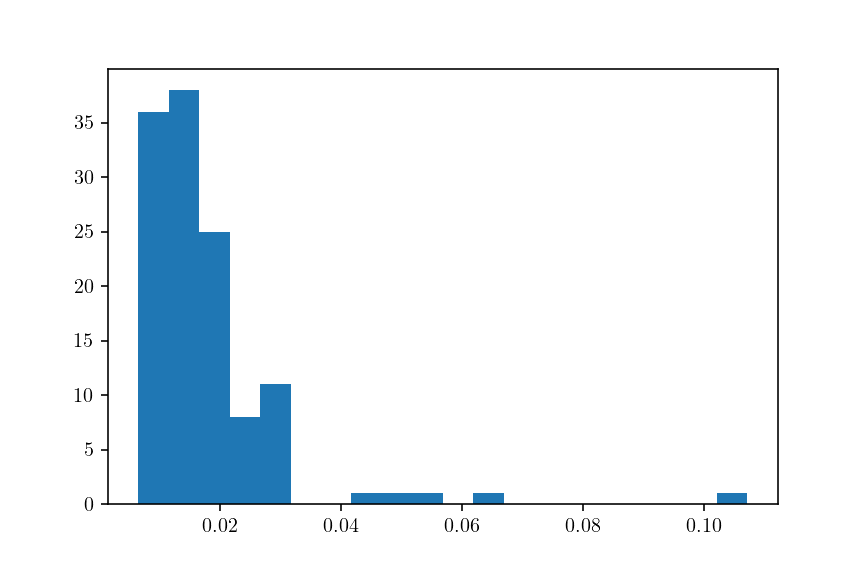

(array([36., 38., 25.,  8., 11.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00659271, 0.01162311, 0.01665352, 0.02168392, 0.02671433,
        0.03174474, 0.03677514, 0.04180555, 0.04683595, 0.05186636,
        0.05689677, 0.06192717, 0.06695758, 0.07198798, 0.07701839,
        0.0820488 , 0.0870792 , 0.09210961, 0.09714001, 0.10217042,
        0.10720083]),
 <a list of 20 Patch objects>)

In [45]:
plt.figure()
plt.hist(t_err_1, bins=20)

In [46]:
t_err_1

array([0.01138311, 0.00874413, 0.01410605, 0.00949838, 0.02546591,
       0.00933767, 0.01122649, 0.01834108, 0.00889274, 0.01898562,
       0.04506244, 0.0189997 , 0.00906693, 0.01241464, 0.04919817,
       0.01513518, 0.01206315, 0.00837683, 0.01233098, 0.01779233,
       0.10720083, 0.01719777, 0.02948011, 0.01034628, 0.01372297,
       0.01854066, 0.01385674, 0.01387365, 0.00951609, 0.02079277,
       0.0309729 , 0.03128951, 0.01594049, 0.01246974, 0.02064953,
       0.01138346, 0.01071958, 0.00788148, 0.01669657, 0.02208997,
       0.02367854, 0.01724588, 0.01316386, 0.0116348 , 0.02858916,
       0.06530254, 0.01231816, 0.01147979, 0.01406047, 0.01388706,
       0.01422821, 0.01632178, 0.01871685, 0.01252701, 0.01475003,
       0.0114891 , 0.01937522, 0.02362459, 0.02573877, 0.01971402,
       0.01597014, 0.02114709, 0.05200607, 0.02070817, 0.01130844,
       0.02883876, 0.01907982, 0.01774321, 0.01467578, 0.02202843,
       0.01114749, 0.01212963, 0.01844034, 0.01686361, 0.01155

## Errors for the single drop

In [59]:
def res_error(time):
    a = t_raw[np.where(t_raw >= time)]
    
    return (a[1] - a[0])/np.sqrt(12)
#     return a[1] - a[0]

In [80]:
drop_idx = 60

narrow_size = t[narrow_end_1[drop_idx]] - t[narrow_start_1[drop_idx]]
error_slopes = np.sqrt(t_err_start_1[drop_idx]**2 + t_err_end_1[drop_idx]**2)
error_resolution = np.sqrt(res_error(t[narrow_end_1[drop_idx]])**2 +
                           res_error(t[narrow_start_1[drop_idx]])**2 )

wide_size = t[wide_end_1[drop_idx]] - t[wide_start_1[drop_idx]]

print(f'{error_slopes = }, {error_resolution = }')

error = np.sqrt(error_resolution**2 + error_slopes**2)

print(f'size = {narrow_size} +- {error} [s]')

error_slopes = 0.01744803372095212, error_resolution = 0.010004165798991735
size = 3.8600000000000136 +- 0.020112613307603718 [s]


In [81]:
wide_size

5.819999999999936

In [83]:
v = 50/(t[narrow_start_2[drop_idx]] - t[narrow_start_1[drop_idx]])
v

0.8629616845012074

In [85]:
narrow_size*v

3.3310321021746723